## Tag-to-Image Recommendation Demo

**Nov 13, 2019**

---

In [1]:
import os
import sys
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import constants
# ! pip install textacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.nlp_util.textacy_util import *
from src.preprocessing import process_utils
from src.models import t2i_recsys

In [2]:
#get training path
train_dir = constants.TRAIN_DIR
clean_dir = constants.CLEAN_DIR
art_prefix = constants.Text_Prefix
img_prefix = constants.Media_Prefix
#tag types
tag_types = ['org', 'place', 'subject','person']
article_summary = pd.read_csv(f'{train_dir}/{art_prefix}summary.csv')
image_summary =  pd.read_csv(f'{train_dir}/{img_prefix}summary.csv')
#preview dir
preview_dir = f'{constants.DATA_DIR}/preview'

In [3]:
###helper functions for demo
def if_valid(csv_entry):
    "check whether an entry is nan or empty string"
    try:
        np.isnan(csv_entry)
        return False
    except:
        if csv_entry in ['','nan']:
            return False
        else:
            return True
        
def get_headline(idx):
    "get image caption"
    at = list()
    for tt in tag_types:
        data = pd.read_csv(f'{clean_dir}/{img_prefix}summary.csv')
        subset = data[data.id == idx]
    return subset.headline.values

def get_tags(idx, prefix, tag_types):
    "get list of tags"
    at = list()
    for tt in tag_types:
        data = pd.read_csv(f'{clean_dir}/{prefix}{tt}.csv')
        subset = data[data.id == idx]
        tag_list = subset[f'{tt}_tag'].values
        for t in tag_list:
            #check validity of tag
            if if_valid(t):
                at.append(t)
    return at

def output_img(idx_list):
    for idx in idx_list:
        print(f'ID: {idx}')
        print(f'HEADLINE: {get_headline(idx)[0]}')
        print('TAGS: ', get_tags(idx, img_prefix, tag_types))
        img_file = f'{preview_dir}/{idx}.jpg'
        fig, ax = plt.subplots()
        img = plt.imread(img_file)
        ax.imshow(img)
        plt.show()

def prediction_demo(exp_id, recommend_size, method):
    
    print(f'Preping prediction for article id {exp_id} ...\n')
    #get full text for example
    text = article_summary[article_summary.id == exp_id].full_text.values[0]
    #change to spacy doc string
    en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
    doc = textacy.make_spacy_doc(text, lang=en)
    #get article tags
    exp_tags = get_tags(exp_id, art_prefix, tag_types)
    print(f'Getting ranked article tags ...\n')
    #get textrank tags
    _, textrank_score, art_ranked_tags = extract_textrank_from_text(text, tagging_API_entities = exp_tags)
    print()
    print(f'Ranked Tags:')
    print(art_ranked_tags, '\n')
    #recommend images
    t2i_object = t2i_recsys.T2I(exp_id, art_ranked_tags, list(textrank_score))
    print(f'Searching for associated images ...\n')
    t2i_object.get_associated_images()
    print(f'Recommending {recommend_size} images ...\n')
    predicted_img_idx = t2i_object.predict(output_size = recommend_size, method = method)
    print(f'Recommended images: ')
    output_img(predicted_img_idx) 
    print(f'True images: ')
    output_img(t2i_object.img_idx_omit)


In [4]:
### random example

# exp_id = np.random.choice(article_summary.id.values)
# prediction_demo(exp_id, 3)

In [5]:
# from sklearn.metrics.pairwise import cosine_similarity

In [4]:
### good example
### 680f273eacb74008a3529baa006e37b1
exp_id = '680f273eacb74008a3529baa006e37b1'
prediction_demo(exp_id, 3, method = 'dot_product')

Preping prediction for article id 680f273eacb74008a3529baa006e37b1 ...

Getting ranked article tags ...

Entities before textrank: ['Business' 'Crime' 'Eastern Europe' 'Europe' 'Gdansk' 'General news'
 'Government and politics' 'Henryk Jankowski'
 'Industrial products and services' 'Labor issues' 'Local governments'
 'Municipal governments' 'Poland' 'Religion' 'Religious issues'
 'Religious scandals' 'Sexual abuse' 'Sexual abuse by clergy'
 'Shipbuilding' 'Social affairs' 'Social issues'
 'Transportation and shipping' 'Transportation equipment manufacturing'
 'Violent crime']

Ranked Tags:
['Gdansk', 'Henryk Jankowski', 'Gdansk', 'Poland'] 

Searching for associated images ...

2 associated images found 

Recommending 3 images ...



ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Preping prediction for article id f7330062afcd4991bac3d98c56ea8d99 ...

Getting ranked article tags ...

Entities before textrank: ['Arizona' 'Crime' 'General news' 'Homicide' 'North America' 'Phoenix'
 'Sexual assault' 'Tommy Thompson' 'United States' 'Violent crime']

Ranked Tags:
['Arizona', 'Tommy Thompson', 'Phoenix'] 

Searching for associated images ...

1 associated images found 

Recommending 3 images ...

(78021, 78021)
Recommended images: 
ID: 979f80e4782b4c989fc01772761abcc8
HEADLINE: Incapacitated Woman Birth
TAGS:  ['Arizona', 'United States', 'North America', 'Phoenix', 'United States', 'North America', 'Phoenix', 'Arizona']


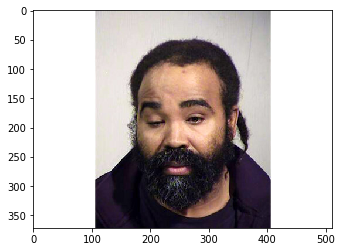

ID: f78f88a578484c0faf6a09a1d8afe3e0
HEADLINE: Prison-Door Lock Problem
TAGS:  ['Arizona state government', 'United States', 'North America', 'Arizona', 'Phoenix', 'Yuma']


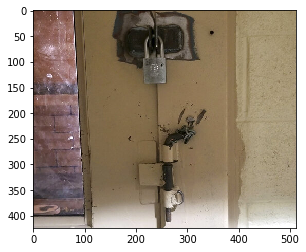

ID: 67ddf402407f45288c5aec45d50bcc2e
HEADLINE: Arizona Budget
TAGS:  ['Arizona', 'United States', 'North America', 'Phoenix', 'Government budgets', 'Government finance', 'Government business and finance', 'Business', 'Government and politics', 'State budgets', 'State governments']


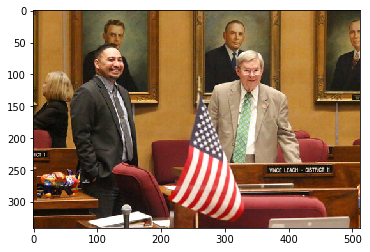

True images: 
ID: 54755b0254c049b692b2f4463eba2caa
HEADLINE: Treatment Center-Homicide
TAGS:  ['United States', 'North America', 'Arizona', 'Homicide', 'Violent crime', 'Crime', 'General news']


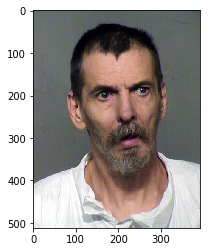

In [8]:
### bad example
### f7330062afcd4991bac3d98c56ea8d99
exp_id = 'f7330062afcd4991bac3d98c56ea8d99'
prediction_demo(exp_id, 3, method = 'cosine_distance')

Preping prediction for article id c879d2f00d8740e5abe4fe5d1ae430d9 ...

Getting ranked article tags ...

Entities before textrank: ['Crime' 'Detroit' 'General news' 'Hit-and-run' 'Law and order'
 'Legal proceedings' 'Michigan' 'North America' 'Reckless endangerment'
 'Sentencing' 'United States']

Ranked Tags:
['Detroit'] 

Searching for associated images ...

1 associated images found 

Recommending 3 images ...

(78021, 78021)
Recommended images: 
ID: 7fdbc9d7bc25453687555b51066cfe1c
HEADLINE: Failing Detroit Streetlights
TAGS:  ['Detroit', 'Michigan', 'United States', 'North America']


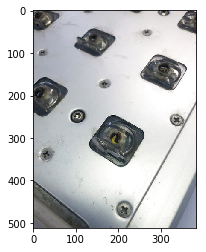

ID: 598ccb7d7f0346d984677f6adef4f426
HEADLINE: Judge-Birthday
TAGS:  ['United States', 'North America', 'Detroit', 'Michigan']


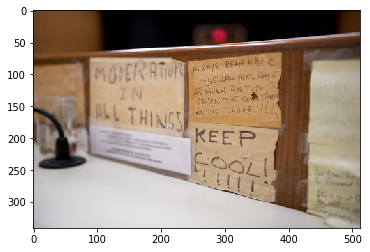

ID: 4d8953a0ca5e4177991751fcacd5ab08
HEADLINE: Police Raid-Girl Killed
TAGS:  ['United States', 'North America', 'Michigan', 'Detroit', 'Crime', 'General news', 'Homicide', 'Violent crime']


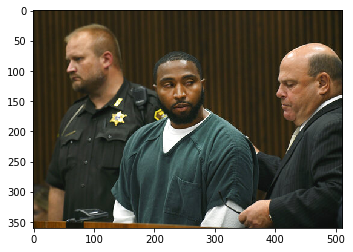

True images: 
ID: fde7f685dc8e48d598da84aef65ee469
HEADLINE: Detroit Officer Dies
TAGS:  ['Michigan', 'United States', 'North America', 'Detroit']


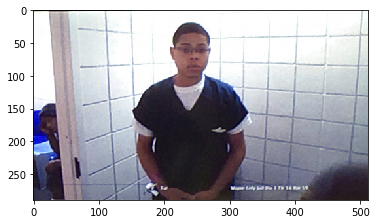

In [10]:
### difficult-to-tell example
### c879d2f00d8740e5abe4fe5d1ae430d9
exp_id = 'c879d2f00d8740e5abe4fe5d1ae430d9' 
prediction_demo(exp_id, 3, method = 'cosine_distance')